# Cluster searching

## Classic file reading

In [25]:
# read the network details
def readNet(fileName):
    f = open(fileName, "r")
    net = {}
    n = int(f.readline())
    net['noNodes'] = n
    mat = []
    for i in range(n):
        mat.append([])
        line = f.readline()
        elems = line.split(" ")
        for j in range(n):
            mat[-1].append(int(elems[j]))
    net["mat"] = mat 
    degrees = []
    noEdges = 0
    for i in range(n):
        d = 0
        for j in range(n):
            if (mat[i][j] == 1):
                d += 1
            if (j > i):
                noEdges += mat[i][j]
        degrees.append(d)
    net["noEdges"] = noEdges
    net["degrees"] = degrees
    f.close()
    return net

## GML file reading

In [26]:
import networkx as nx

def readNetGml(fileName):
    g = nx.read_gml(fileName,label="id")
    dict={}
    i = 0
    for node in g.nodes:
        dict[node] = i
        i += 1
    mat = [[0 for i in range(len(dict))] for j in range(len(dict))]

    for pereche in g.edges:
        mat[dict[pereche[0]]][dict[pereche[1]]] = 1
        mat[dict[pereche[1]]][dict[pereche[0]]] = 1

    degree = []
    for el in g.degree:
        degree.append(el[1])

    net = {}
    net['noNodes'] = len(g.nodes)
    net['mat'] = mat
    net['noEdges'] = len(g.edges)
    net['degrees'] = degree
    return net

## Reading data

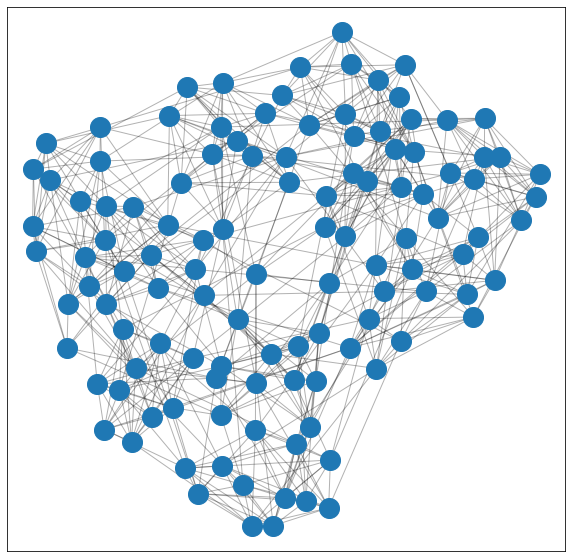

In [27]:

#network=readNet('mine.in')
#network=readNetGml('dolphins.gml')
network=readNetGml('football.gml')

import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt 
import warnings 

warnings.simplefilter('ignore')

A=np.matrix(network["mat"])
G=nx.from_numpy_matrix(A)
pos = nx.spring_layout(G)  # compute graph layout
plt.figure(figsize=(10, 10))  # image is 8 x 8 inches 
nx.draw_networkx_nodes(G, pos, node_size=400, cmap=plt.cm.RdYlBu)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.show(G)

## Just some plot testing and warm up

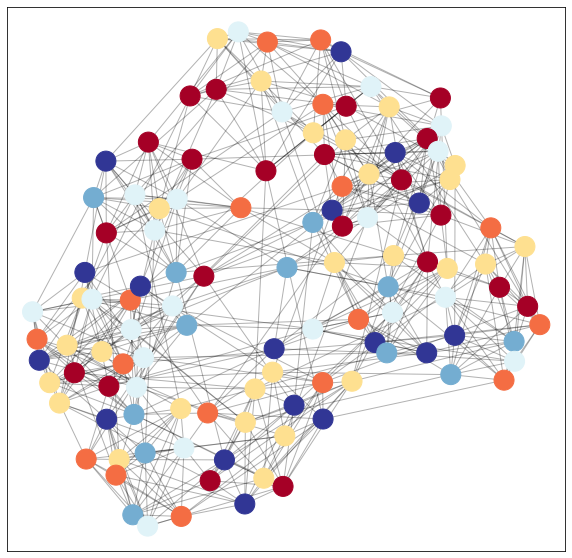

In [28]:
# plot a particular division in communities
import random

#communities = [1,2,1,2,1, 1]

communities=[]

for _ in range(network["noNodes"]):
    communities.append(random.randint(1,6))

A=np.matrix(network["mat"])
G=nx.from_numpy_matrix(A)
pos = nx.spring_layout(G)  # compute graph layout
plt.figure(figsize=(10, 10))  # image is 8 x 8 inches 
nx.draw_networkx_nodes(G, pos, node_size = 400, cmap = plt.cm.RdYlBu, node_color = communities)
nx.draw_networkx_edges(G, pos, alpha = 0.3)
plt.show(G)

## Modularity function

In [29]:
def modularity(communities, param):

    #print(communities)

    noNodes = param['noNodes']
    mat = param['mat']
    degrees = param['degrees']
    noEdges = param['noEdges']  
    M = 2 * noEdges
    Q = 0.0
    for i in range(0, noNodes):
        for j in range(0, noNodes):
            if (communities[i] == communities[j]):
               Q += (mat[i][j] - degrees[i] * degrees[j] / M)
    return Q * 1 / M

# Chromosome

In [30]:
from random import randint


class Chromosome:
    def __init__(self, problParam = None):
        self.__problParam = problParam
        self.__repres = []

        #self.random_choice_init()
        self.__twenty_percent()

        #print(self.__repres)

        self.normalise()

        #print(self.__repres)
    
    def __random_choice_init(self):

        gene=[]
        for _ in range(problParam['noNodes']):
            gene.append(randint(0,problParam['noNodes']-1))
        self.__repres=gene
 
        self.__fitness = 0.0

    def __twenty_percent(self):

        gene=[]
        for _ in range(problParam['noNodes']):
            gene.append(-1)

        nodes=problParam['noNodes']
        nr_candidates=20*nodes//100
        color=0
        mat=self.__problParam['network']['mat']
        
        for _ in range(nr_candidates):
            
            candidat=randint(0,nodes-1)
            
            gene[candidat]=color

            for i in range(0,nodes):
                if mat[candidat][i] == 1: 
                    gene[i]=color

            color+=1
                    
        for i in range(problParam['noNodes']):
            if gene[i]==-1: 
                 gene[i]=randint(0,problParam['noNodes']-1)
            
        self.__repres=gene
        self.__fitness = 0.0
        

    def normalise(self):
        
        value=-1 
        color=self.__repres[0]

        dic={}

        for i in range(len(self.__repres)):
            if self.__repres[i] in dic: 
                self.__repres[i]=dic[self.__repres[i]] 
            else: 
                value+=1
                dic[self.__repres[i]]=value
                self.__repres[i]=dic[self.__repres[i]]

    

    @property
    def repres(self):      
        return self.__repres
    
    @property
    def fitness(self):
        return self.__fitness 
    
    @repres.setter
    def repres(self, l = []):
        self.__repres = l 
        self.normalise()
    
    @fitness.setter 
    def fitness(self, fit = 0.0):
        self.__fitness = fit 
    
    def crossover(self, c):
        
        # source-destination method
        
        random_node=randint(0,len(self.__repres)-1)
        newrepres=c.repres[:]

        for i in range(0,len(self.__repres)):
            if self.__repres[i] == self.__repres[random_node]:
                newrepres[i]=self.__repres[random_node]
        
        offspring=Chromosome(self.__problParam)
        offspring.repres=newrepres

        return offspring

    
    def mutation(self):

        #classic mutation
        '''
        random_node=randint(0,len(self.__repres)-1)
        label_node=randint(0,len(self.__repres)-1)
        while label_node==random_node or self.__repres[label_node]==self.__repres[random_node]:
            label_node=randint(0,len(self.__repres)-1)
        
        self.__repres[random_node]=self.__repres[label_node]
        ''' 

        random_node=randint(0,len(self.__repres)-1)
        mat=self.__problParam['network']['mat']
        label_node=randint(0,len(self.__repres)-1)

        while label_node==random_node or mat[random_node][label_node]==0:
            label_node=randint(0,len(self.__repres)-1)
        self.__repres[random_node]=self.__repres[label_node]

            
        
    def __str__(self):
        return '\nChromo: ' + str(self.__repres) + ' has fit: ' + str(self.__fitness)
    
    def __repr__(self):
        return self.__str__()
    
    def __eq__(self, c):
        return self.__repres == c.__repres and self.__fitness == c.__fitness


In [31]:
gaParam = {'popSize' : 10, 'noGen' : 50}
problParam= {'noNodes' : network['noNodes'], 'function' : modularity, 'network' : network }

c= Chromosome(problParam)



# GA class

In [32]:


class GA:
    def __init__(self, param = None, problParam = None):
        self.__param = param
        self.__problParam = problParam
        self.__population = []
        
    @property
    def population(self):
        return self.__population
    
    def initialisation(self):

        for _ in range(0, self.__param['popSize']):
            c = Chromosome(self.__problParam)

           # print(c.repres)

            self.__population.append(c)

    
    def evaluation(self):
        for c in self.__population:
            c.fitness = self.__problParam['function'](c.repres,self.__problParam['network'])
            
    def bestChromosome(self):
        best = self.__population[0]
        for c in self.__population:
            if (c.fitness > best.fitness):
                best = c
        return best
        
    def worstChromosome(self):
        best = self.__population[0]
        for c in self.__population:
            if (c.fitness < best.fitness):
                best = c
        return best

    def selection(self):
        pos1 = randint(0, self.__param['popSize'] - 1)
        pos2 = randint(0, self.__param['popSize'] - 1)
        if (self.__population[pos1].fitness > self.__population[pos2].fitness):
            return pos1
        else:
            return pos2 
        
    
    def oneGeneration(self):
        newPop = []
        for _ in range(self.__param['popSize']):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2)
            off.mutation()
            newPop.append(off)
        self.__population = newPop
        self.evaluation()

    def oneGenerationElitism(self):
        newPop = [self.bestChromosome()]
        for _ in range(self.__param['popSize'] - 1):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2)
            off.mutation()
            newPop.append(off)
        self.__population = newPop
        self.evaluation()
        
    def oneGenerationSteadyState(self):
        for _ in range(self.__param['popSize']):
            p1 = self.__population[self.selection()]
            p2 = self.__population[self.selection()]
            off = p1.crossover(p2)
            off.mutation()
            off.fitness = self.__problParam['function'](off.repres,self.__problParam['network'])
            worst = self.worstChromosome()
            if (off.fitness > worst.fitness):
                worst = off 

In [33]:
def plotAFunction(xref, yref, x, y, xoptimal, yoptimal, message):    
    plt.plot(xref, yref, 'b-')
    #plt.plot(x, y, 'ro', xoptimal, yoptimal, 'bo')
    plt.plot(x,y,'ro')
    plt.plot(xoptimal,yoptimal,'bo')
    plt.title(message)
    plt.show()
    plt.pause(0.9)
    plt.clf()


In [34]:
def community_analysis(comunitate):
    dic= {}
    size = 0
    for i in range(len(comunitate)):
        if comunitate[i] in dic:
            dic[comunitate[i]].append(i)
        else:
            dic[comunitate[i]]=[i]
            size+=1
    return size,dic

# Spin to win

In [35]:

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import math
import numpy as np 


gaParam = {'popSize' : 15, 'noGen' : 100}

problParam= {'noNodes' : network['noNodes'], 'function' : modularity, 'network' : network }

#c=Chromosome(problParam)



ga = GA(gaParam, problParam)
ga.initialisation()
ga.evaluation()


all_time_best=[]
all_time_best_fitness=-1000000

for g in range(gaParam['noGen']):
    
    #plotting preparation


    #logic alg
    #ga.oneGeneration()
    ga.oneGenerationElitism()
    #ga.oneGenerationSteadyState()
    
    bestChromo = ga.bestChromosome()
    if all_time_best_fitness< bestChromo.fitness:
        all_time_best=bestChromo.repres[:]
        all_time_best_fitness=bestChromo.fitness
    

    '''
    A=np.matrix(network["mat"])
    G=nx.from_numpy_matrix(A)
    pos = nx.spring_layout(G)  # compute graph layout
    plt.figure(figsize=(10, 10))  # image is 8 x 8 inches
    nx.draw_networkx_nodes(G, pos, node_size = 400, cmap = plt.cm.RdYlBu, node_color = bestChromo.repres)
    nx.draw_networkx_edges(G, pos, alpha = 0.3)
    plt.show(G)
    ''' 

    
    size,analiza=community_analysis(all_time_best)

    print(size)
    print(all_time_best_fitness)
    print(analiza)
    print(size)
    print("--------------------------------------------------------")
    
    
    '''

    print('Best solution in generation ' + str(g) + ' is: x = ' + str(bestChromo.repres) + ' f(x) = ' + str(bestChromo.fitness))
    '''

    




 95, 96, 97, 113], 1: [1, 25, 33, 37, 45, 80, 89, 103, 105, 109], 2: [2, 3, 5, 10, 14, 26, 40, 43, 52, 72, 74, 81, 84, 98, 102, 107], 3: [6, 12, 13, 15, 18, 31, 32, 34, 38, 39, 42, 47, 54, 59, 60, 61, 64, 71, 85, 99, 100, 106], 4: [7, 8, 21, 22, 51, 68, 77, 78, 108, 111], 5: [11, 24, 28, 50, 69, 90], 6: [19, 29, 30, 35, 36, 55, 79, 82, 94, 101], 7: [44, 48, 57, 66, 75, 86, 91, 92, 112], 8: [46, 49, 53, 67, 73, 83, 88, 104, 110, 114]}
9
--------------------------------------------------------
9
0.5260596749030205
{0: [0, 4, 9, 16, 17, 20, 23, 27, 41, 56, 58, 62, 63, 65, 70, 76, 87, 93, 95, 96, 97, 113], 1: [1, 25, 33, 37, 45, 80, 89, 103, 105, 109], 2: [2, 3, 5, 10, 14, 26, 40, 43, 52, 72, 74, 81, 84, 98, 102, 107], 3: [6, 12, 13, 15, 18, 31, 32, 34, 38, 39, 42, 47, 54, 59, 60, 61, 64, 71, 85, 99, 100, 106], 4: [7, 8, 21, 22, 51, 68, 77, 78, 108, 111], 5: [11, 24, 28, 50, 69, 90], 6: [19, 29, 30, 35, 36, 55, 79, 82, 94, 101], 7: [44, 48, 57, 66, 75, 86, 91, 92, 112], 8: [46, 49, 53, 67,

# The best so far

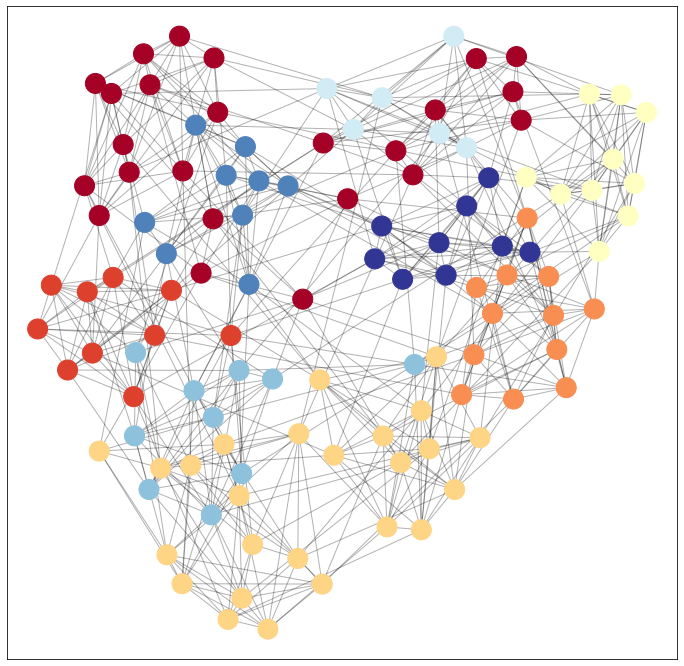

Best solution:
9
0.5720043957665719
{0: [0, 4, 9, 16, 17, 20, 23, 27, 41, 56, 58, 59, 62, 63, 65, 70, 76, 87, 93, 95, 96, 97, 104, 113], 1: [1, 25, 33, 37, 45, 80, 89, 103, 105, 109], 3: [2, 6, 12, 13, 14, 15, 18, 26, 31, 32, 34, 38, 39, 42, 43, 47, 54, 60, 61, 64, 71, 85, 99, 100, 106], 2: [3, 5, 10, 40, 52, 72, 74, 81, 84, 98, 102, 107], 4: [7, 8, 21, 22, 51, 68, 77, 78, 108, 111], 5: [11, 24, 28, 50, 69, 90], 6: [19, 29, 30, 35, 36, 55, 79, 82, 94, 101], 7: [44, 48, 57, 66, 75, 86, 91, 92, 112], 8: [46, 49, 53, 67, 73, 83, 88, 110, 114]}
9
--------------------------------------------------------


In [36]:
A=np.matrix(network["mat"])
G=nx.from_numpy_matrix(A)
pos = nx.spring_layout(G)  # compute graph layout
plt.figure(figsize=(12, 12))  # image is 8 x 8 inches 

nx.draw_networkx_nodes(G, pos, node_size = 400, cmap = plt.cm.RdYlBu, node_color = all_time_best)
nx.draw_networkx_edges(G, pos, alpha = 0.3)
plt.show(G)

size,analiza=community_analysis(all_time_best)

print("Best solution:")
print(size)
print(all_time_best_fitness)
print(analiza)
print(size)
print("--------------------------------------------------------")   

#print('Best solution  is: x = ' + str(all_time_best) + ' f(x) = ' + str(all_time_best_fitness))